# Loading Dataset

In [23]:
import pandas as pd
df= pd.read_excel("TASK_dataset.xlsx")
df.head()

,Original Sentence,Transformed Sentence,Label
0,"He said, 'I am going to the market.'",He said that he was going to the market.,Direct to Indirect Speech
1,"He said, 'I am going to the market.'",He said that he was going to the market.,Direct to Indirect Speech
2,The room is cleaned by the maid every day.,The maid cleans the room every day.,Passive to Active
3,She is always punctual.,She is not always late.,Positive to Negative
4,She is not unkind.,She is kind.,Negative to Positive


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Original Sentence     1020 non-null   object
 1   Transformed Sentence  1020 non-null   object
 2   Label                 1020 non-null   object
dtypes: object(3)
memory usage: 24.0+ KB


# Data Preprocessing : Label Encoding and Stratified splitting

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Inputs and Labels
X = df["Transformed Sentence"]
y = df["Label"]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split (Stratified)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Check shapes
len(X_train), len(X_val), len(X_test)


(612, 204, 204)

# BERT Tokenization: converting the sentences into input tensors

In [26]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
def tokenize_data(sentences):
    return tokenizer(
        list(sentences),
        padding=True,
        truncation=True,
        max_length = 128,
        return_tensors="pt"
    )

train_encodings = tokenize_data(X_train)
val_encodings = tokenize_data(X_val)
test_encodings = tokenize_data(X_test)


d:\Task\.venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Creating custom dataset class for tokenized inputs

In [ ]:
import torch
from torch.utils.data import Dataset

# This class helps convert tokenized data + labels into a dataset format that can be used for training
class SentenceDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings  # the tokenized inputs
        self.labels = labels        # the encoded labels 

    def __getitem__(self, idx):
        # For every index, return input_ids, attention_mask and label
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx])  # convert label to tensor
        }

    def __len__(self):
        return len(self.labels)  # number of samples


# Preparing Final dataset for training, Validation and testing

In [28]:
train_dataset = SentenceDataset(train_encodings, y_train)
val_dataset = SentenceDataset(val_encodings, y_val)
test_dataset = SentenceDataset(test_encodings, y_test)


# Loading Pre-trained BERT model for multiclass classification

In [ ]:
from transformers import BertForSequenceClassification


num_labels = len(le.classes_)

# Load the BERT model for classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Pre-trained model
    num_labels=num_labels # Number of output classes
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Defining Evaluation Metrics, Training arguments & train model

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
# Define the metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Load the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

# Set training arguments 
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,                       
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,               
    learning_rate=2e-5,                         
    weight_decay=0.01,            
    evaluation_strategy="epoch",       
    save_strategy="epoch",               
    load_best_model_at_end=True, 
    logging_dir="./logs",
    logging_steps=10,
    metric_for_best_model="f1",      
    greater_is_better=True       
)

# Create Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/385 [00:00<?, ?it/s]d:\Task\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  3%|▎         | 10/385 [00:16<08:26,  1.35s/it]

{'loss': 1.8292, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.13}


  5%|▌         | 20/385 [00:28<07:41,  1.26s/it]

{'loss': 1.7515, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.26}


  8%|▊         | 30/385 [00:41<07:12,  1.22s/it]

{'loss': 1.6794, 'learning_rate': 6e-06, 'epoch': 0.39}


 10%|█         | 40/385 [00:54<07:09,  1.24s/it]

{'loss': 1.5269, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.52}


 13%|█▎        | 50/385 [01:07<07:22,  1.32s/it]

{'loss': 1.395, 'learning_rate': 1e-05, 'epoch': 0.65}


 16%|█▌        | 60/385 [01:21<07:24,  1.37s/it]

{'loss': 1.2275, 'learning_rate': 1.2e-05, 'epoch': 0.78}


 18%|█▊        | 70/385 [01:33<06:25,  1.22s/it]

{'loss': 1.0592, 'learning_rate': 1.4e-05, 'epoch': 0.91}


                                                
 20%|██        | 77/385 [01:46<06:59,  1.36s/it]

{'eval_loss': 0.698636531829834, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 3.6363, 'eval_samples_per_second': 56.101, 'eval_steps_per_second': 7.15, 'epoch': 1.0}


d:\Task\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 21%|██        | 80/385 [02:02<18:11,  3.58s/it]

{'loss': 0.8315, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.04}


 23%|██▎       | 90/385 [02:14<06:51,  1.39s/it]

{'loss': 0.6133, 'learning_rate': 1.8e-05, 'epoch': 1.17}


 26%|██▌       | 100/385 [02:27<05:55,  1.25s/it]

{'loss': 0.4554, 'learning_rate': 2e-05, 'epoch': 1.3}


 29%|██▊       | 110/385 [02:38<05:24,  1.18s/it]

{'loss': 0.309, 'learning_rate': 1.929824561403509e-05, 'epoch': 1.43}


 31%|███       | 120/385 [02:51<05:32,  1.26s/it]

{'loss': 0.1826, 'learning_rate': 1.8596491228070176e-05, 'epoch': 1.56}


 34%|███▍      | 130/385 [03:02<04:46,  1.12s/it]

{'loss': 0.1272, 'learning_rate': 1.7894736842105264e-05, 'epoch': 1.69}


 36%|███▋      | 140/385 [03:14<04:45,  1.17s/it]

{'loss': 0.0717, 'learning_rate': 1.719298245614035e-05, 'epoch': 1.82}


 39%|███▉      | 150/385 [03:27<04:46,  1.22s/it]

{'loss': 0.0507, 'learning_rate': 1.649122807017544e-05, 'epoch': 1.95}


                                                 
 40%|████      | 154/385 [03:34<04:18,  1.12s/it]

{'eval_loss': 0.025480037555098534, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 2.834, 'eval_samples_per_second': 71.983, 'eval_steps_per_second': 9.174, 'epoch': 2.0}


d:\Task\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 42%|████▏     | 160/385 [03:52<07:00,  1.87s/it]

{'loss': 0.035, 'learning_rate': 1.578947368421053e-05, 'epoch': 2.08}


 44%|████▍     | 170/385 [04:05<04:26,  1.24s/it]

{'loss': 0.026, 'learning_rate': 1.5087719298245615e-05, 'epoch': 2.21}


 47%|████▋     | 180/385 [04:17<03:53,  1.14s/it]

{'loss': 0.0225, 'learning_rate': 1.4385964912280704e-05, 'epoch': 2.34}


 49%|████▉     | 190/385 [04:28<03:57,  1.22s/it]

{'loss': 0.0197, 'learning_rate': 1.3684210526315791e-05, 'epoch': 2.47}


 52%|█████▏    | 200/385 [04:40<03:28,  1.13s/it]

{'loss': 0.0168, 'learning_rate': 1.2982456140350879e-05, 'epoch': 2.6}


 55%|█████▍    | 210/385 [04:51<03:13,  1.11s/it]

{'loss': 0.0158, 'learning_rate': 1.2280701754385966e-05, 'epoch': 2.73}


 57%|█████▋    | 220/385 [05:03<03:22,  1.23s/it]

{'loss': 0.0141, 'learning_rate': 1.1578947368421053e-05, 'epoch': 2.86}


 60%|█████▉    | 230/385 [05:14<02:52,  1.11s/it]

{'loss': 0.0136, 'learning_rate': 1.0877192982456142e-05, 'epoch': 2.99}


                                                 
 60%|██████    | 231/385 [05:18<02:48,  1.10s/it]

{'eval_loss': 0.009040547534823418, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 2.812, 'eval_samples_per_second': 72.547, 'eval_steps_per_second': 9.246, 'epoch': 3.0}


d:\Task\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 62%|██████▏   | 240/385 [05:41<03:36,  1.49s/it]

{'loss': 0.0131, 'learning_rate': 1.017543859649123e-05, 'epoch': 3.12}


 65%|██████▍   | 250/385 [05:52<02:33,  1.13s/it]

{'loss': 0.0119, 'learning_rate': 9.473684210526315e-06, 'epoch': 3.25}


 68%|██████▊   | 260/385 [06:04<02:24,  1.16s/it]

{'loss': 0.0112, 'learning_rate': 8.771929824561405e-06, 'epoch': 3.38}


 70%|███████   | 270/385 [06:15<02:08,  1.12s/it]

{'loss': 0.0108, 'learning_rate': 8.070175438596492e-06, 'epoch': 3.51}


 73%|███████▎  | 280/385 [06:26<01:57,  1.12s/it]

{'loss': 0.0102, 'learning_rate': 7.368421052631579e-06, 'epoch': 3.64}


 75%|███████▌  | 290/385 [06:38<02:00,  1.26s/it]

{'loss': 0.01, 'learning_rate': 6.666666666666667e-06, 'epoch': 3.77}


 78%|███████▊  | 300/385 [06:51<01:51,  1.31s/it]

{'loss': 0.0094, 'learning_rate': 5.964912280701755e-06, 'epoch': 3.9}


                                                 
 80%|████████  | 308/385 [07:04<01:34,  1.23s/it]

{'eval_loss': 0.006463382858783007, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 2.9552, 'eval_samples_per_second': 69.031, 'eval_steps_per_second': 8.798, 'epoch': 4.0}


d:\Task\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 81%|████████  | 310/385 [07:18<05:18,  4.24s/it]

{'loss': 0.0091, 'learning_rate': 5.263157894736842e-06, 'epoch': 4.03}


 83%|████████▎ | 320/385 [07:30<01:20,  1.24s/it]

{'loss': 0.0091, 'learning_rate': 4.56140350877193e-06, 'epoch': 4.16}


 86%|████████▌ | 330/385 [07:41<01:05,  1.19s/it]

{'loss': 0.0088, 'learning_rate': 3.859649122807018e-06, 'epoch': 4.29}


 88%|████████▊ | 340/385 [07:55<00:56,  1.25s/it]

{'loss': 0.0086, 'learning_rate': 3.157894736842105e-06, 'epoch': 4.42}


 91%|█████████ | 350/385 [08:07<00:43,  1.24s/it]

{'loss': 0.008, 'learning_rate': 2.456140350877193e-06, 'epoch': 4.55}


 94%|█████████▎| 360/385 [08:19<00:31,  1.26s/it]

{'loss': 0.0087, 'learning_rate': 1.7543859649122807e-06, 'epoch': 4.68}


 96%|█████████▌| 370/385 [08:30<00:17,  1.13s/it]

{'loss': 0.0085, 'learning_rate': 1.0526315789473685e-06, 'epoch': 4.81}


 99%|█████████▊| 380/385 [08:42<00:05,  1.20s/it]

{'loss': 0.0083, 'learning_rate': 3.5087719298245616e-07, 'epoch': 4.94}


                                                 
100%|██████████| 385/385 [08:51<00:00,  1.17s/it]

{'eval_loss': 0.005853089038282633, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 2.9909, 'eval_samples_per_second': 68.207, 'eval_steps_per_second': 8.693, 'epoch': 5.0}


100%|██████████| 385/385 [09:15<00:00,  1.44s/it]

{'train_runtime': 555.9539, 'train_samples_per_second': 5.504, 'train_steps_per_second': 0.693, 'train_loss': 0.3486604578793049, 'epoch': 5.0}


TrainOutput(global_step=385, training_loss=0.3486604578793049, metrics={'train_runtime': 555.9539, 'train_samples_per_second': 5.504, 'train_steps_per_second': 0.693, 'train_loss': 0.3486604578793049, 'epoch': 5.0})

# Prediction on Test set

In [31]:
# Get test predictions
predictions = trainer.predict(test_dataset)

# Convert predicted logits to actual labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


d:\Task\.venv\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 26/26 [00:02<00:00,  9.34it/s]


# Classification Report

In [32]:
from sklearn.metrics import classification_report

# Get original label names
label_names = le.classes_

# Print precision, recall, f1-score per class
print(classification_report(y_true, y_pred, target_names=label_names))


                           precision    recall  f1-score   support

        Active to Passive       1.00      1.00      1.00        34
Direct to Indirect Speech       1.00      1.00      1.00        34
Indirect to Direct Speech       1.00      1.00      1.00        34
     Negative to Positive       1.00      1.00      1.00        34
        Passive to Active       1.00      1.00      1.00        34
     Positive to Negative       1.00      1.00      1.00        34

                 accuracy                           1.00       204
                macro avg       1.00      1.00      1.00       204
             weighted avg       1.00      1.00      1.00       204



# Visualizing using Confusion matrix

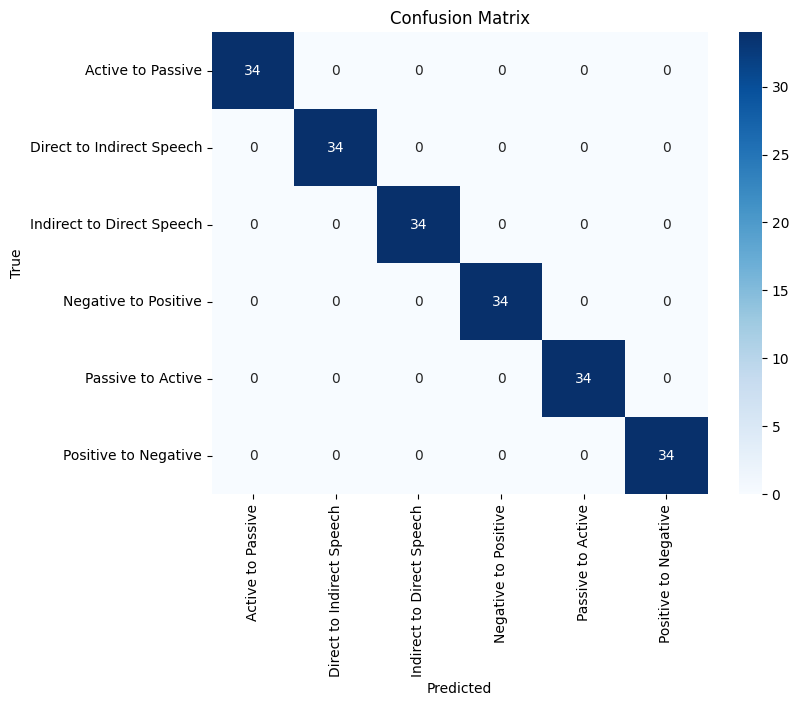

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# # Save the fine-tuned model
# model.save_pretrained("finetuned_model/")

# # Save the tokenizer
# tokenizer.save_pretrained("finetuned_model/")


('finetuned_model/tokenizer_config.json',
 'finetuned_model/special_tokens_map.json',
 'finetuned_model/vocab.txt',
 'finetuned_model/added_tokens.json')

# Attention Mechanism


🔹 Sample Sentence: The designer creates a modern dress.
✅ Predicted Label: Active to Passive
🎯 Confidence: 98.58%


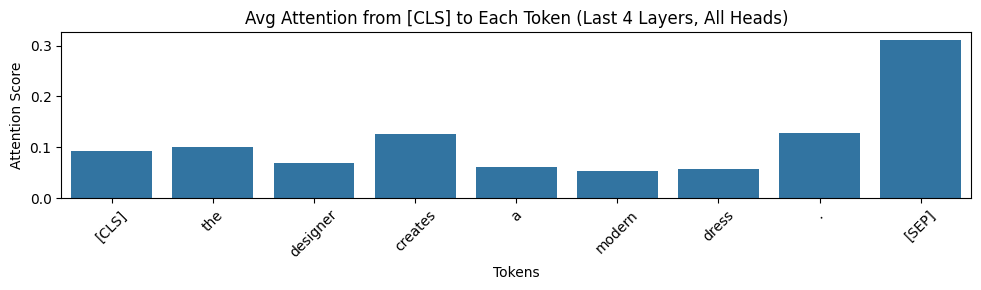

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F

#  Load model and tokenizer with attention output enabled
model = BertForSequenceClassification.from_pretrained("finetuned_model/", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("finetuned_model/")
model.eval()

#  Define label mapping 
label_names = [
    "Active to Passive",
    "Passive to Active",
    "Direct to Indirect",
    "Indirect to Direct",
    "Positive to Negative",
    "Negative to Positive"
]

#  Input sentence for prediction and explanation
sample_sentence = "The designer creates a modern dress."
print(" Sample Sentence:", sample_sentence)

#  Tokenize
inputs = tokenizer(sample_sentence, return_tensors="pt")

#  Predict label and  extract attention
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    predicted_label = label_names[predicted_class]
    confidence = probs[0][predicted_class].item() * 100

    attentions = outputs.attentions  # [layers, batch, heads, from_token, to_token]

#  Show prediction
print(f"✅ Predicted Label: {predicted_label}")
print(f"🎯 Accuracy: {confidence:.2f}%")

#  Tokens
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

#  Average attention over last 4 layers and all heads (CLS to all tokens)
cls_attention = torch.stack(attentions[-4:]).mean(dim=0)[0, :, 0, :].mean(dim=0).numpy()

# Plot attention
plt.figure(figsize=(10, 3))
sns.barplot(x=tokens, y=cls_attention)
plt.title("Avg Attention from [CLS] to Each Token (Last 4 Layers, All Heads)")
plt.xticks(rotation=45)
plt.ylabel("Attention Score")
plt.xlabel("Tokens")
plt.tight_layout()
plt.show()

